Vincent Cammisa GENAI Assignment 3

Task 1: Load and Preprocess the SVHN Dataset

- Use the commands provided above to download and load the SVHN dataset.
- Preprocess the images (normalize and reshape).
- Display the shape of the training and test datasets.

In [1]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-16 00:59:01--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  3.11MB/s    in 68s     

2024-10-16 01:00:09 (2.56 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-16 01:00:09--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  2.39MB/s    in 28s     

2024-10-16 01:00:37 (2.20 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [2]:
import numpy as np
from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


Task 2: Build a Variational Autoencoder

- Define the encoder and decoder architecture for the VAE.
- Create the complete VAE model using the function: build_vae(latent_dim)
- Ensure it can take a specified latent dimension.

In [3]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
#ENCODER
latent_dim = EMBEDDING_DIM
encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input") # Changed input shape to (32, 32, 3)
x = layers.Conv2D(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(encoder_input)
x = layers.Conv2D(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2D(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x) # Use the defined latent_dim
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,444 (396.27 KB)

 Trainable params: 101,444 (396.27 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#DECODER

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

decoder_output = layers.Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [9]:
def build_vae(latent_dim):
    vae = VAE(encoder, decoder)
    return vae

vae_model = build_vae(EMBEDDING_DIM)
vae_model.compile(optimizer='adam')

Task 3: Train the VAE with Different Latent Dimensions

- Train the VAE with latent dimensions of 2, 5, and 10. Use the following for-loop in main:
- Monitor the training process and evaluate the model's performance.

In [10]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - kl_loss: 1.4070 - reconstruction_loss: 333.4413 - total_loss: 334.8484 - val_kl_loss: 2.2818 - val_loss: 323.6547 - val_reconstruction_loss: 321.3729
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 2.5050 - reconstruction_loss: 321.4223 - total_loss: 323.9273 - val_kl_loss: 2.5512 - val_loss: 320.5588 - val_reconstruction_loss: 318.0076
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 2.6229 - reconstruction_loss: 319.9318 - total_loss: 322.5547 - val_kl_loss: 2.6484 - val_loss: 318.9148 - val_reconstruction_loss: 316.2663
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 2.7559 - reconstruction_loss: 318.7435 - total_loss: 321.4995 - val_kl_loss: 2.9338 - val_loss: 316.7190 - val_reconstruction_loss: 313.7852
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 2.8077 - reconstruction_loss: 318.2139 - total_loss: 321.0215 - val_kl_loss

- We have a low kl_loss which is good
- we also have a high reconstruction loss and consideering how fast our model trained id like to test outside experiments with higher epochs
- our total and validation loss are also high but close which displays good generalization, also will rerun with double the epochs maybe

Create visualizations of original and reconstructed images for the largest latent dimension.

In [11]:
predicts = 5000
images = x_test[:predicts]
labels = y_test[:predicts]
z_mean, z_log_var, reconstructions = vae.predict(images)

print("Examples of Original Images")
display(images)
print("Reconstructed Images")
display(reconstructions)

z_mean, z_var, z = encoder.predict(images)
print(z[:10])

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Examples of Original Images


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructed Images


array([[[[0.25624526, 0.24670409, 0.23406743],
         [0.2566257 , 0.24333379, 0.2317806 ],
         [0.24792342, 0.23554192, 0.22855999],
         ...,
         [0.21654642, 0.21048959, 0.20684105],
         [0.21729618, 0.20684811, 0.2057529 ],
         [0.2206265 , 0.21105129, 0.20664234]],

        [[0.2624044 , 0.24970174, 0.23464307],
         [0.26788363, 0.25029662, 0.23456906],
         [0.259685  , 0.24414706, 0.23278598],
         ...,
         [0.22019504, 0.21104442, 0.2016129 ],
         [0.22241661, 0.21037734, 0.20302267],
         [0.22305025, 0.21228851, 0.21145692]],

        [[0.26430038, 0.25237852, 0.24801461],
         [0.2653948 , 0.25079352, 0.2378017 ],
         [0.2620103 , 0.24952039, 0.24180552],
         ...,
         [0.22342777, 0.21523482, 0.21021926],
         [0.22636293, 0.21693102, 0.20899604],
         [0.2296463 , 0.21627414, 0.21128888]],

        ...,

        [[0.28288665, 0.27343488, 0.26983193],
         [0.2833251 , 0.27585918, 0.26953492]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[[ 1.1470003   0.03083169]
 [-1.0362449  -0.5714018 ]
 [-0.62678015  0.44953865]
 [-0.9419123  -0.9014176 ]
 [-1.1341393  -0.30691433]
 [ 0.15119319  0.31691745]
 [ 2.787236   -2.2797241 ]
 [ 0.9722995  -2.0603397 ]
 [-1.0128984   0.7717497 ]
 [-0.56672204  0.19338746]]


In [13]:
from scipy.stats import norm

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


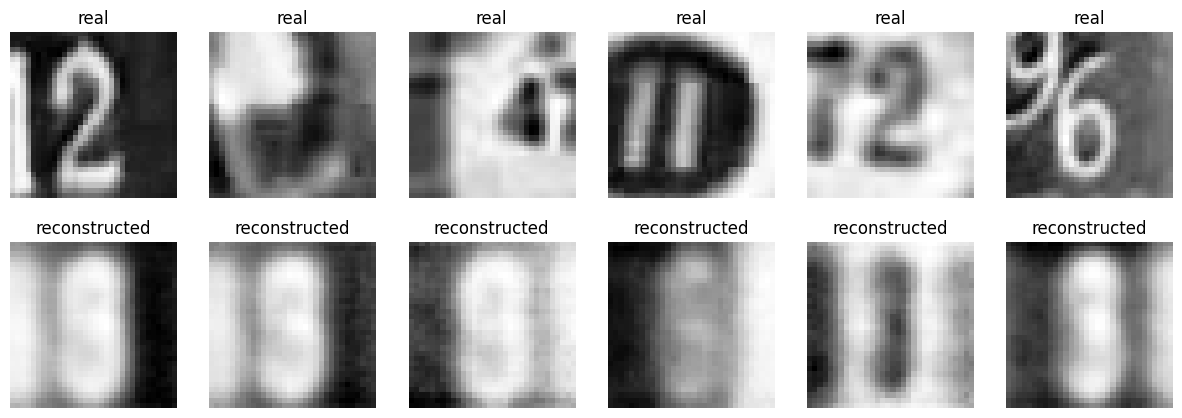

In [16]:
grid_width, grid_height = (4, 2)

random = np.random.choice(x_test.shape[0], 6, replace=False)
real = x_test[random]
z_mean,z_log_var,z = encoder.predict(real)
reconstructed_img = decoder.predict(z)

fig, axes = plt.subplots(2, 6, figsize=(15, 5))

for i in range(6):
    axes[0, i].imshow(real[i, :, :, 0], cmap="Greys")
    axes[0, i].axis("off")
    axes[0, i].set_title("real")

for i in range(6):
    axes[1, i].imshow(reconstructed_img[i, :, :, 0], cmap="Greys")
    axes[1, i].axis("off")
    axes[1, i].set_title("reconstructed")



#Discussion

Model Overall Grade (50 epoch; Batch 128):B-

Clarity:

With a setting of batch size 128 and epochs of 50 the clarity of the reconstructed image is mediocre, I think with further training, and feeding the data through the VAE’s more will enhance the clarity will decrease the loss values obtained through training. The clarity on the real is much better then the reconstructed

Distortion:

There is a level of distortion to the reconstructed images. There is a high level of loss in the training process at each dimension which might indicate the need to alter the model's structure. Overall, there are losses in detail and reconfiguration is at hand.

Variability:

The images show low variability as the results are pretty uniform in their shortcomings. They all display a level of blur as well as the same thickness of the digits. However, we may want to point out the difference in performance for different colors. For the images with darker backgrounds, it is a bit harder to make out what the digits are, and the blur seems to be enhanced.

Generalization:

From the outputs my VAE has grasped the general distribution of the data. It handles unseen images well, resembling the training data.